In [ ]:
print('ble')

In [ ]:
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import matplotlib.dates as mdates
import datetime

%pylab inline --no-import-all

#directory = '/storage/experiments/2021/0726_bourka_zabori' 
#directory = '/storage/experiments/2021/0807_bourka_sobeslav' 
#directory = '/storage/experiments/2021/0725_bourka_ratmirov'
directory = '/storage/experiments/2021/video_lightning_highlights'
#directory = '/storage/experiments/2022/0424_bourka_trebon'
#directory = '/storage/experiments/2022/0520_bourka_nakv'

#filename = '1627370541.5541592'
#filename = '1628432100.1519039'
#filename = '1627300500.3458862'
filename = '1627301803.0339904'
filename = '1627302288.9546976'
#filename = '1627302745.846055'
#filename = '2022.05.20.19.11.39.428680'
#filename = '2022.04.24.15.19.53.891159'

video_file = directory + '/video/' + filename + '.mp4'
csv_file = directory + '/video/' + filename + '.mp4.csv'
#wfm_file = directory + '/slavia/' + filename + '.wfm'
wfm_file = directory + '/osciloskop/' + filename + '.wfm'


# generate light curves and STP antenna data into video

In [ ]:
break
dt = np.dtype([('a', 'u1')])
bytes_read = np.fromfile(wfm_file, dtype=dt)

offset = 0x10
SetupSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C
LAdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x1c
CHdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x30
MemDepth = int.from_bytes(bytes_read[offset:offset+4], "big")
print(CHdataSize, MemDepth)
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x39
df2 = pd.DataFrame(bytes_read[offset+1:offset+CHdataSize:2])
df2['time']=pd.to_datetime(df2.index*4e-9, unit='s', origin='unix') # fillin of correct sample time
df2.set_index('time', inplace=True)

xx2 = df2.resample('1us', closed='left').mean()

#time offset
xx2.index = xx2.index + datetime.timedelta(milliseconds=655)

y = pd.read_csv(csv_file)
y['time'] = (y.index)*(1/1610)

#---------------------------------------------------

fig, (ax1,  ax2) = plt.subplots(figsize=(15, 8), nrows=2, sharex=True)
#plt.rcParams.update({'font.size': 13})

ax1.plot(xx2-128, label='STP antenna')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax1.set_ylabel('dB/dt [a.u.]', c='b')
ax1.grid()
#ax1.legend(loc = "upper left")
ax1.legend()

y['time'] = pd.to_datetime((y.index)*(1/1612.38), unit='s')

#ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera', marker='.')
ax2.plot(y['time'], y['0'], c='red', label='camera')
ax2.set_yscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Illuminance [a.u.]', c='r')
ax2.grid()
ax2.legend(loc = "upper right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
#plt.ylim(90,10e2)
plt.show()

#---------------------------------------------------

fig, (ax1,  ax2) = plt.subplots(figsize=(10.02, 2), nrows=2, sharex=True, frameon=False)

w = 9.58
h = 2

#fig.set_size_inches(w,h)
fig.tight_layout()

ax1.axis('off')    
ax2.axis('off')  

plt.subplots_adjust(wspace=0, hspace=0)

ax1.plot(xx2-128, label='STP antenna', color='black')
ax1.legend(loc=(0.1,0.5))

y['time'] = pd.to_datetime((y.index)*(1/1612.38), unit='s')

ax2.plot(y['time'], y['0'], label='camera', color='black')
ax2.set_yscale('log')
ax2.legend(loc=(0.1,0.5))
ax2.set_xlim(pd.to_datetime(0.0, unit='s'),pd.to_datetime(2., unit='s'))

fig.savefig(directory + '/video/output/' + filename + '.mp4.csv.2.png', dpi=100, bbox_inches='tight', pad_inches = 0)
plt.show()



In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/video/output')
except:
    pass

#for f in glob.iglob(directory + "/video/*.mp4"): # generator, search immediate subdirectories 
f = video_file
s = f.split('/')
st = s[len(s)-1]
print(st)

b = np.zeros(30000)

vcap = cv2.VideoCapture(f)

if vcap.isOpened(): 
    # get vcap property 
    width  = vcap.get(3)  # float `width`
    height = vcap.get(4)  # float `height`

print(width, ' x ', height)
vcap.release()

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
out = cv2.VideoWriter(directory + '/video/output/' + st + '.STP.mp4', fourcc, 20.0, (round(width),round(height)+140))

cap = cv2.VideoCapture(f)
video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(video_length)

img = cv2.imread(directory + '/video/output/' + st + '.csv.2.png')
img_not = cv2.bitwise_not(img)

# Center coordinates
center_coordinates = (round(width/2), round(height/2))
# Radius of circle
radius = round(width/2)-50
# Line thickness of 2 px
thickness = 2

count = 0
while True:
    ret,frame = cap.read()
    if not(ret):
        break

    count = count + 1
    if(count>0):
        for n in range(0,256):
            for i in range(round(width)-20,round(width)):
                frame[n+20,i] = n

        #frame_log = log(42,frame)
        frame_color = frame[:round(width)-40]

        frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)

        color = (0, 255, 0) # green
        frame_color = cv2.circle(frame_color, center_coordinates, radius, color, thickness)
        font = cv2.FONT_HERSHEY_DUPLEX
        text = "W"
        position = (round(width/2)-10, 80)
        cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
        text = "E"
        position = (round(width/2)-10, round(width) -70)
        cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
        text = "N"
        position = (60, round(width/2)+10)
        cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
        text = "S"
        position = (round(width)-80, round(width/2)+10)
        cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
        color = (255, 255, 255) # white
        text = "0"
        position = (round(width) - 40, 40)
        cv2.putText(frame_color, text, position, font, color=color, thickness = 1, fontScale=0.6)
        text = "255"
        position = (round(width) - 60, 275)
        cv2.putText(frame_color, text, position, font, color=color, thickness = 1, fontScale=0.6)

        v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])

        try:
            v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])
        except:
            print('frame:', frame.shape, 'frame_color:', frame_color.shape, 'statusbar:', frame[round(width)-40:round(width)].shape)
            break

        pointer = round(count*(width/video_length))
        cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),4)
        cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),4)
        out.write(v_img)
        
        
        #pointer = round(count*(width/video_length))
        #cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),4)
        #cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),4)
        #out.write(v_img)

cap.release()
out.release()
print(f)
        
print('end')

1627302288.9546976.mp4
928.0  x  928.0
3224


error: OpenCV(4.5.2) /build/source/modules/core/src/matrix_operations.cpp:110: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].cols == src[0].cols && src[i].type() == src[0].type() in function 'vconcat'


# wfm file

In [272]:
dt = np.dtype([('a', 'u1')])
bytes_read = np.fromfile(wfm_file, dtype=dt)

In [273]:
offset = 0x10
SetupSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C
LAdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x1c
CHdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x30
MemDepth = int.from_bytes(bytes_read[offset:offset+4], "big")
print(CHdataSize, MemDepth)
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x39
#ch1 = list(bytes_read[offset:offset+CHdataSize:2])
#ch2 = bytes_read[offset+1:offset+CHdataSize:2]
df2 = pd.DataFrame(bytes_read[offset+1:offset+CHdataSize:2])
df1 = pd.DataFrame(bytes_read[offset:offset+CHdataSize:2])
df1['time']=pd.to_datetime(df1.index*4e-9, unit='s', origin='unix') # fillin of correct sample time
df1.set_index('time', inplace=True)
df2['time']=pd.to_datetime(df2.index*4e-9, unit='s', origin='unix') # fillin of correct sample time
df2.set_index('time', inplace=True)

500000032 125000000


In [274]:
#xx1 = df1.resample('10us', closed='left').mean()
#xx2 = df2.resample('500ns', closed='left').mean()
xx1 = df1.resample('8us', closed='left').mean()
xx2 = df2.resample('1us', closed='left').mean()

#time offset
xx1.index = xx1.index + datetime.timedelta(milliseconds=655)
xx2.index = xx2.index + datetime.timedelta(milliseconds=655)

In [275]:
y = pd.read_csv(csv_file)
y['time'] = (y.index)*(1/1610)

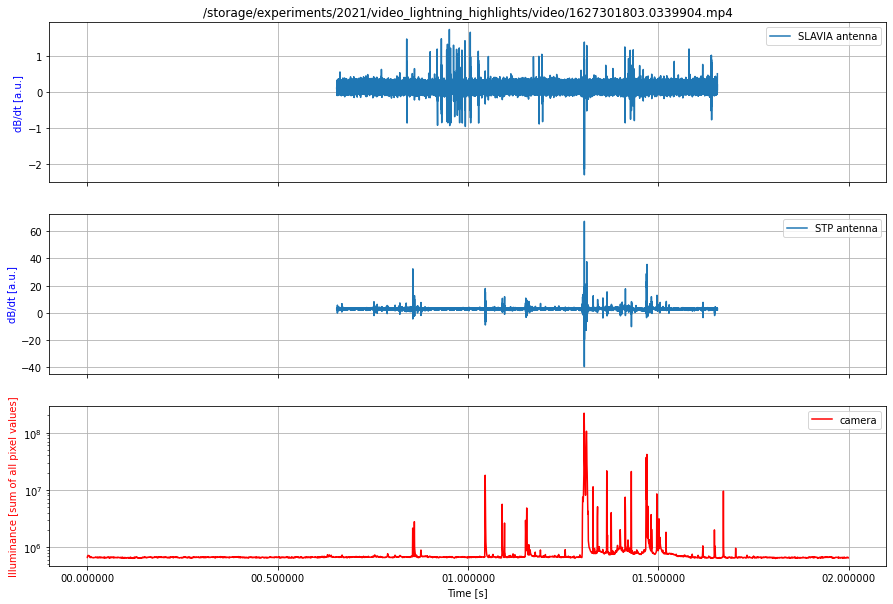

In [276]:
fig, (ax0, ax1,  ax2) = plt.subplots(figsize=(15, 10), nrows=3, sharex=True)

ax0.plot(xx1-123, label='SLAVIA antenna')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax0.set_ylabel('dB/dt [a.u.]', c='b')
ax0.grid()
#ax0.legend(loc = "upper left")
ax0.legend()
ax0. set_title(video_file)

ax1.plot(xx2-128, label='STP antenna')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax1.set_ylabel('dB/dt [a.u.]', c='b')
ax1.grid()
#ax1.legend(loc = "upper left")
ax1.legend()

#ax1.set_xlim(pd.to_datetime(0.66, unit='s'),pd.to_datetime(0.72, unit='s'))
#!!!ax1.set_xlim(pd.to_datetime(0.5, unit='s'),pd.to_datetime(2., unit='s'))
#ax1.set_xlim(pd.to_datetime(1., unit='s'),pd.to_datetime(1.19, unit='s'))

y['time'] = pd.to_datetime((y.index)*(1/1612.38), unit='s')

#ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera', marker='.')
ax2.plot(y['time'], y['0'], c='red', label='camera')
ax2.set_yscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax2.grid()
ax2.legend(loc = "upper right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
#plt.ylim(90,10e2)

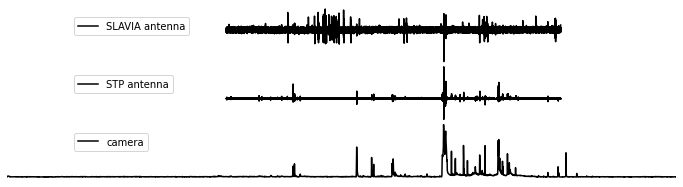

In [277]:
#fig = plt.figure(figsize=(9.58,2),frameon=False) # Notice the equal aspect ratio

fig, (ax0, ax1,  ax2) = plt.subplots(figsize=(10.02, 3), nrows=3, sharex=True, frameon=False)

w = 9.58
h = 2

#fig.set_size_inches(w,h)
fig.tight_layout()

#ax0 = fig.add_subplot(3,1,1)
#ax1 = fig.add_subplot(3,1,2, sharex=ax0)
#ax2 = fig.add_subplot(3,1,3, sharex=ax1)

ax0.axis('off')    
ax1.axis('off')    
ax2.axis('off')  

#ax0.set_xticklabels([])
#ax1.set_xticklabels([])
#ax2.set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

ax0.plot(xx1-123, label='SLAVIA antenna', color='black')
ax0.legend(loc=(0.1,0.5))

ax1.plot(xx2-128, label='STP antenna', color='black')
ax1.legend(loc=(0.1,0.5))

y['time'] = pd.to_datetime((y.index)*(1/1612.38), unit='s')

ax2.plot(y['time'], y['0'], label='camera', color='black')
ax2.set_yscale('log')
ax2.legend(loc=(0.1,0.5))
ax2.set_xlim(pd.to_datetime(0.0, unit='s'),pd.to_datetime(2., unit='s'))

fig.savefig(directory + '/video/output/' + filename + '.mp4.csv.png', dpi=100, bbox_inches='tight', pad_inches = 0)


In [280]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/video/output')
except:
    pass

for f in glob.iglob(directory + "/video/*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)
    
    b = np.zeros(30000)
    
    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        
    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/video/output/' + st + 'antenna.mp4', fourcc, 20.0, (round(width),round(height)+240))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)
    
    img = cv2.imread(directory + '/video/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)
    
    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-50
    # Line thickness of 2 px
    thickness = 2
    
    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break

        count = count + 1
        if(count>1000):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            #frame_log = log(42,frame)
            frame_color = frame[:round(width)-40] #+20

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)

            color = (0, 255, 0) # green
            frame_color = cv2.circle(frame_color, center_coordinates, radius, color, thickness)
            font = cv2.FONT_HERSHEY_DUPLEX
            text = "W"
            position = (round(width/2)-10, 80)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            text = "E"
            position = (round(width/2)-10, round(width) -70)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            text = "N"
            position = (60, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            text = "S"
            position = (round(width)-80, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            color = (255, 255, 255) # white
            text = "0"
            position = (round(width) - 40, 40)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 1, fontScale=0.6)
            text = "255"
            position = (round(width) - 60, 275)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 1, fontScale=0.6)

            v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,240),(pointer,260),(0,255,0),4)
            cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),4)
            cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),4)
            out.write(v_img)
        
    cap.release()
    out.release()
    print(f)
    #break
        
print('end')

1627302745.846055.mp4
928.0  x  928.0
3225
/storage/experiments/2021/video_lightning_highlights/video/1627302745.846055.mp4
1627301803.0339904.mp4
928.0  x  928.0
3224
/storage/experiments/2021/video_lightning_highlights/video/1627301803.0339904.mp4
1627302288.9546976.mp4
928.0  x  928.0
3224
/storage/experiments/2021/video_lightning_highlights/video/1627302288.9546976.mp4
end


In [252]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/video/output')
except:
    pass

for f in glob.iglob(directory + "/video/*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)
    
    b = np.zeros(30000)
    
    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        
    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/video/output/' + st + '.BW.mp4' , fourcc, 20.0, (round(width),round(height)+240))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)
    
    img = cv2.imread(directory + '/video/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)
    
    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break

        #frame_log = log(42,frame)
        #frame_color = cv2.applyColorMap(frame_log, cv2.COLORMAP_JET)
        
        v_img = cv2.vconcat([img_not, frame])
        #pointer = round(count*(928/video_length))
        pointer = round(count*(width/video_length))
        cv2.line(v_img,(pointer,240),(pointer,260),(0,255,0),4)
        cv2.line(v_img,(pointer,140),(pointer,160),(0,255,0),4)
        cv2.line(v_img,(pointer,60),(pointer,80),(0,255,0),4)
        count = count + 1
        out.write(v_img)
        
    cap.release()
    out.release()
    print(f)
        
print('end')

1627302745.846055.mp4
928.0  x  928.0
3225
/storage/experiments/2021/video_lightning_highlights/video/1627302745.846055.mp4
1627301803.0339904.mp4
928.0  x  928.0
3224
/storage/experiments/2021/video_lightning_highlights/video/1627301803.0339904.mp4
1627302288.9546976.mp4
928.0  x  928.0
3224
/storage/experiments/2021/video_lightning_highlights/video/1627302288.9546976.mp4
end


# 4 CH

In [1]:
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import matplotlib.dates as mdates
import datetime

%pylab inline --no-import-all

#directory = '/storage/experiments/2021/0726_bourka_zabori' 
#directory = '/storage/experiments/2021/0807_bourka_sobeslav' 
#directory = '/storage/experiments/2021/0725_bourka_ratmirov'
directory = '/storage/experiments/2021/video_lightning_highlights'
#directory = '/storage/experiments/2022/0424_bourka_trebon'
directory = '/storage/experiments/2022/0520_bourka_nakv'

#filename = '1627370541.5541592'
#filename = '1628432100.1519039'
#filename = '1627300500.3458862'
filename = '1627301803.0339904'
filename = '1627302288.9546976'
#filename = '1627302745.846055'
filename = '2022.05.20.19.11.39.428680'
#filename = '2022.04.24.15.19.53.891159'

video_file = directory + '/video/' + filename + '.mp4'
csv_file = directory + '/video/' + filename + '.mp4.csv'
#wfm_file = directory + '/slavia/' + filename + '.wfm'
wfm_file = directory + '/osciloskop/' + filename + '.wfm'


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
dt = np.dtype([('a', 'u1')])
bytes_read = np.fromfile(wfm_file, dtype=dt)

In [3]:
offset = 0x10
SetupSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C
LAdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x1c
CHdataSize = int.from_bytes(bytes_read[offset:offset+4], "big")
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x30
MemDepth = int.from_bytes(bytes_read[offset:offset+4], "big")
print(CHdataSize, MemDepth)
offset = 0x14 + SetupSize + 0x1C + 0x1D + LAdataSize + 0x39
#ch1 = list(bytes_read[offset:offset+CHdataSize:2])
#ch2 = bytes_read[offset+1:offset+CHdataSize:2]
df4 = pd.DataFrame(bytes_read[offset+3:offset+CHdataSize:4])
df3 = pd.DataFrame(bytes_read[offset+2:offset+CHdataSize:4])
df2 = pd.DataFrame(bytes_read[offset+1:offset+CHdataSize:4])
df1 = pd.DataFrame(bytes_read[offset:offset+CHdataSize:4])
df1['time']=pd.to_datetime(df1.index*2e-8, unit='s', origin='unix') # fillin of correct sample time
df1.set_index('time', inplace=True)
df2['time']=pd.to_datetime(df2.index*2e-8, unit='s', origin='unix') # fillin of correct sample time
df2.set_index('time', inplace=True)
df3['time']=pd.to_datetime(df3.index*2e-8, unit='s', origin='unix') # fillin of correct sample time
df3.set_index('time', inplace=True)
df4['time']=pd.to_datetime(df4.index*2e-8, unit='s', origin='unix') # fillin of correct sample time
df4.set_index('time', inplace=True)


500000032 125000000


In [65]:
xx1 = df1.resample('10us', closed='left').mean()
xx2 = df2.resample('1us', closed='left').mean()
xx3 = df3.resample('1us', closed='left').mean()
xx4 = df4.resample('1us', closed='left').mean()

#time offset
xx1.index = xx1.index + datetime.timedelta(milliseconds=-402) # 655
xx2.index = xx2.index + datetime.timedelta(milliseconds=-402)
xx3.index = xx3.index + datetime.timedelta(milliseconds=-402)
xx4.index = xx4.index + datetime.timedelta(milliseconds=-402)


In [5]:
y = pd.read_csv(csv_file)
y['time'] = (y.index)*(1/1610)

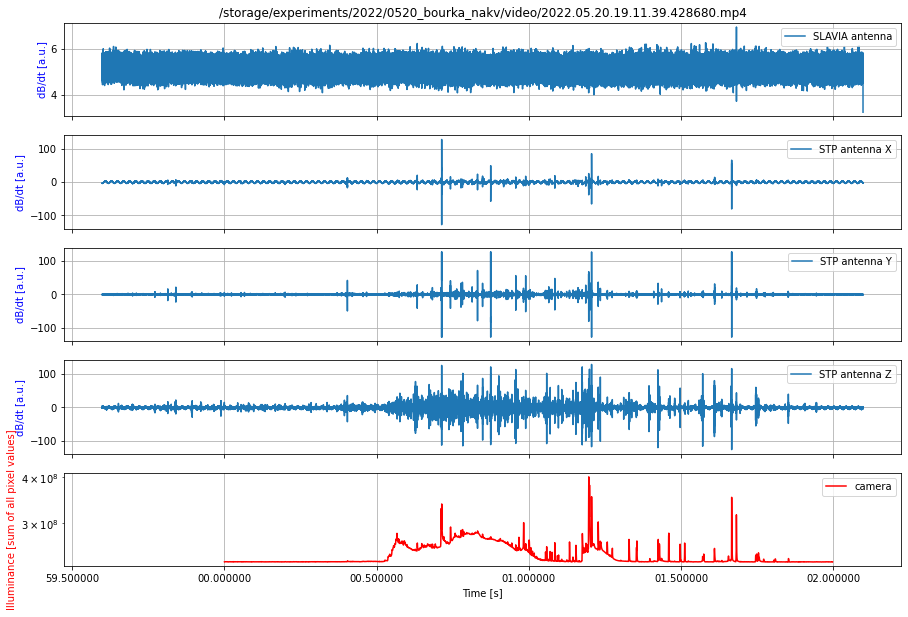

In [66]:
fig, (ax0, ax1,  ax2, ax3, ax4) = plt.subplots(figsize=(15, 10), nrows=5, sharex=True)

ax0.plot(xx1-123, label='SLAVIA antenna')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax0.set_ylabel('dB/dt [a.u.]', c='b')
ax0.grid()
#ax0.legend(loc = "upper left")
ax0.legend()
ax0. set_title(video_file)

ax1.plot(xx2-128, label='STP antenna X')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax1.set_ylabel('dB/dt [a.u.]', c='b')
ax1.grid()
#ax1.legend(loc = "upper left")
ax1.legend()

ax2.plot(xx3-128, label='STP antenna Y')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax2.set_ylabel('dB/dt [a.u.]', c='b')
ax2.grid()
#ax1.legend(loc = "upper left")
ax2.legend()

ax3.plot(xx4-128, label='STP antenna Z')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax3.set_ylabel('dB/dt [a.u.]', c='b')
ax3.grid()
#ax1.legend(loc = "upper left")
ax3.legend()

#ax1.set_xlim(pd.to_datetime(0.66, unit='s'),pd.to_datetime(0.72, unit='s'))
#!!!ax1.set_xlim(pd.to_datetime(0.5, unit='s'),pd.to_datetime(2., unit='s'))
#ax1.set_xlim(pd.to_datetime(1., unit='s'),pd.to_datetime(1.19, unit='s'))

y['time'] = pd.to_datetime((y.index)*(1/1612.38), unit='s')

#ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera', marker='.')
ax4.plot(y['time'], y['0'], c='red', label='camera')
ax4.set_yscale('log')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax4.grid()
ax4.legend(loc = "upper right")
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
#plt.ylim(90,10e2)

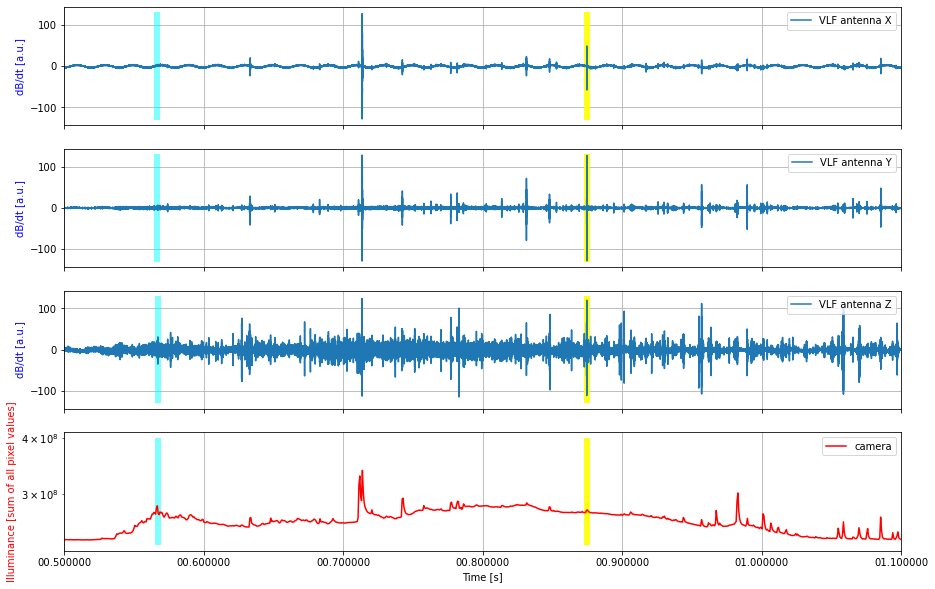

In [69]:
fig, ( ax1,  ax2, ax3, ax4) = plt.subplots(figsize=(15, 10), nrows=4, sharex=True)

ax1.vlines([pd.to_datetime('1970-01-01 00:00:00.56650')],ymin=-130,ymax=130, lw=6, color='cyan', alpha=0.5)
ax1.vlines([pd.to_datetime('1970-01-01 00:00:00.875')],ymin=-130,ymax=130, lw=6, color='yellow', alpha=0.9)
ax1.plot(xx2-128, label='VLF antenna X')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax1.set_xlim(pd.to_datetime('1970-01-01 00:00:00.500000'),pd.to_datetime('1970-01-01 00:00:01.100000'))
ax1.set_ylabel('dB/dt [a.u.]', c='b')
ax1.grid()
#ax1.legend(loc = "upper left")
ax1.legend(loc=1)

ax2.vlines([pd.to_datetime('1970-01-01 00:00:00.56650')],ymin=-130,ymax=130, lw=6, color='cyan', alpha=0.5)
ax2.vlines([pd.to_datetime('1970-01-01 00:00:00.875')],ymin=-130,ymax=130, lw=6, color='yellow', alpha=0.9)
ax2.plot(xx3-128, label='VLF antenna Y')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax2.set_ylabel('dB/dt [a.u.]', c='b')
ax2.grid()
#ax1.legend(loc = "upper left")
ax2.legend(loc=1)

ax3.vlines([pd.to_datetime('1970-01-01 00:00:00.5670')],ymin=-130,ymax=130, lw=6, color='cyan', alpha=0.5)
ax3.vlines([pd.to_datetime('1970-01-01 00:00:00.875')],ymin=-130,ymax=130, lw=6, color='yellow', alpha=0.9)
ax3.plot(xx4-128, label='VLF antenna Z')
#ax1.set_yscale('log')
#ax1.set_ylim(-5,20)
ax3.set_ylabel('dB/dt [a.u.]', c='b')
ax3.grid()
#ax1.legend(loc = "upper left")
ax3.legend(loc=1)

#ax1.set_xlim(pd.to_datetime(0.66, unit='s'),pd.to_datetime(0.72, unit='s'))
#!!!ax1.set_xlim(pd.to_datetime(0.5, unit='s'),pd.to_datetime(2., unit='s'))
#ax1.set_xlim(pd.to_datetime(1., unit='s'),pd.to_datetime(1.19, unit='s'))

y['time'] = pd.to_datetime((y.index)*(1/1612.38), unit='s')

#ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera', marker='.')
ax4.vlines([pd.to_datetime('1970-01-01 00:00:00.5670')],ymin=2.3e8,ymax=4e8, lw=6, color='cyan', alpha=0.5)
ax4.vlines([pd.to_datetime('1970-01-01 00:00:00.875')],ymin=2.3e8,ymax=4e8, lw=6, color='yellow', alpha=0.9)
ax4.plot(y['time'], y['0'], c='red', label='camera')
ax4.set_yscale('log')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax4.grid()
ax4.legend(loc = "upper right")
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%S.%f'))
#plt.ylim(90,10e2)



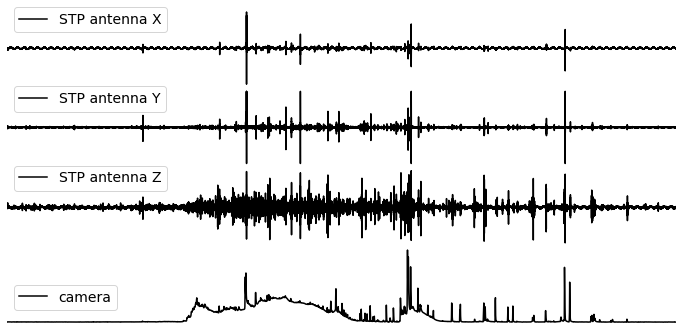

In [99]:
#fig = plt.figure(figsize=(9.58,2),frameon=False) # Notice the equal aspect ratio

fig, (ax0, ax1,  ax2, ax3) = plt.subplots(figsize=(10.02, 5), nrows=4, sharex=True, frameon=False)

w = 9.5
h = 2

#fig.set_size_inches(w,h)
fig.tight_layout()

#ax0 = fig.add_subplot(3,1,1)
#ax1 = fig.add_subplot(3,1,2, sharex=ax0)
#ax2 = fig.add_subplot(3,1,3, sharex=ax1)

ax0.axis('off')    
ax1.axis('off')    
ax2.axis('off')  
ax3.axis('off')  

plt.subplots_adjust(wspace=0, hspace=0)

ax0.plot(xx2-123, label='STP antenna X', color='black')
ax0.legend(loc=(0.01,0.7), fontsize=14)

ax1.plot(xx3-128, label='STP antenna Y', color='black')
ax1.legend(loc=(0.01,0.7), fontsize=14)

ax2.plot(xx4-128, label='STP antenna Z', color='black')
ax2.legend(loc=(0.01,0.7), fontsize=14)

y['time'] = pd.to_datetime((y.index)*(1/1612.38), unit='s')

ax3.plot(y['time'], y['0'], label='camera', color='black')
ax3.set_yscale('log')
ax3.legend(loc=(0.01,0.2), fontsize=14)
ax3.set_xlim(pd.to_datetime(0.0, unit='s'),pd.to_datetime(2., unit='s'))

fig.savefig(directory + '/video/output/' + filename + '.mp4.csv.png', dpi=100, bbox_inches='tight', pad_inches = 0)


In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

#directory = "/storage/experiments/2021/0711_bourka_stiavnica"

# Logarithmic transformation
def log(c, img):
    output = c * np.log(1.0 + img)
    output = np.uint8(output + 0.5)
    return output

try:
    os.mkdir(directory + '/video/output')
except:
    pass

for f in glob.iglob(directory + "/video/*.mp4"): # generator, search immediate subdirectories 
    s = f.split('/')
    st = s[len(s)-1]
    print(st)
    
    b = np.zeros(30000)
    
    vcap = cv2.VideoCapture(f)

    if vcap.isOpened(): 
        # get vcap property 
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        
    print(width, ' x ', height)
    vcap.release()

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    #out = cv2.VideoWriter(directory + '/video/output/' + st , fourcc, 20.0, (928,928+150))
    out = cv2.VideoWriter(directory + '/video/output/' + st + 'antenna.mp4', fourcc, 20.0, (round(width),round(height)+442))

    cap = cv2.VideoCapture(f)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_length)
    
    img = cv2.imread(directory + '/video/output/' + st + '.csv.png')
    img_not = cv2.bitwise_not(img)
    
    # Center coordinates
    center_coordinates = (round(width/2), round(height/2))
    # Radius of circle
    radius = round(width/2)-50
    # Line thickness of 2 px
    thickness = 2
    
    count = 0
    while True:
        ret,frame = cap.read()
        if not(ret):
            break

        count = count + 1
        if(count>600):
            for n in range(0,256):
                for i in range(round(width)-20,round(width)):
                    frame[n+20,i] = n

            (B, G, R) = cv2.split(frame)
            frame = cv2.merge([B,B,B])
            #frame_log = log(42,frame)
            frame_color = frame[:round(width)-40]

            frame_color = cv2.applyColorMap(frame_color, cv2.COLORMAP_JET)

            color = (0, 255, 0) # green
            frame_color = cv2.circle(frame_color, center_coordinates, radius, color, thickness)
            font = cv2.FONT_HERSHEY_DUPLEX
            text = "W"
            position = (round(width/2)-10, 80)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            text = "E"
            position = (round(width/2)-10, round(width) -70)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            text = "N"
            position = (60, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            text = "S"
            position = (round(width)-80, round(width/2)+10)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 2, fontScale=1)
            color = (255, 255, 255) # white
            text = "0"
            position = (round(width) - 40, 40)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 1, fontScale=0.6)
            text = "255"
            position = (round(width) - 60, 275)
            cv2.putText(frame_color, text, position, font, color=color, thickness = 1, fontScale=0.6)

            v_img = cv2.vconcat([img_not, frame_color, frame[round(width)-40:round(width)]])

            pointer = round(count*(width/video_length))
            cv2.line(v_img,(pointer,380),(pointer,400),(0,255,0),4)
            cv2.line(v_img,(pointer,280),(pointer,300),(0,255,0),4)
            cv2.line(v_img,(pointer,180),(pointer,200),(0,255,0),4)
            cv2.line(v_img,(pointer,80),(pointer,100),(0,255,0),4)
            out.write(v_img)
        
    cap.release()
    out.release()
    print(f)
    break
        
print('end')

2022.05.20.19.11.39.428680.mp4
928.0  x  928.0
3222
/storage/experiments/2022/0520_bourka_nakv/video/2022.05.20.19.11.39.428680.mp4
end
